## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")



RMSE of after m0 0.015955927
RMSE of after m1 0.019903485
RMSE of after m3 0.07817939
RMSE of after m4 0.07870821
RMSE of after m0 0.014518581
RMSE of after m1 0.055837248
RMSE of after m3 0.1477848
RMSE of after m4 0.14640383
RMSE of after m0 0.022985889
RMSE of after m1 0.04009601
RMSE of after m3 0.089379124
RMSE of after m4 0.09203076
RMSE of after m0 0.023267046
RMSE of after m1 0.02467512
RMSE of after m3 0.090026364
RMSE of after m4 0.09087419
RMSE of after m0 0.020757074
RMSE of after m1 0.02009003
RMSE of after m3 0.01690196
RMSE of after m4 0.017224463
RMSE of after m0 0.019228224
RMSE of after m1 0.016826741
RMSE of after m3 0.011024926
RMSE of after m4 0.011710198
RMSE of after m0 0.018557398
RMSE of after m1 0.015764339
RMSE of after m3 0.009375972
RMSE of after m4 0.009957707
RMSE of after m0 0.018134614
RMSE of after m1 0.015549683
RMSE of after m3 0.010425117
RMSE of after m4 0.010811509
RMSE of after m0 0.01839736
RMSE of after m1 0.016086038
RMSE of after m3 0.0113804

RMSE of after m3 0.042464074
RMSE of after m4 0.043437213
RMSE of after m0 0.022970745
RMSE of after m1 0.02456015
RMSE of after m3 0.045265682
RMSE of after m4 0.04574689
RMSE of after m0 0.018848438
RMSE of after m1 0.023211105
RMSE of after m3 0.034769718
RMSE of after m4 0.033027027
RMSE of after m0 0.018118193
RMSE of after m1 0.023512002
RMSE of after m3 0.017699838
RMSE of after m4 0.017087316
RMSE of after m0 0.016410066
RMSE of after m1 0.01951677
RMSE of after m3 0.022396846
RMSE of after m4 0.02111449
RMSE of after m0 0.017455647
RMSE of after m1 0.01914478
RMSE of after m3 0.022819554
RMSE of after m4 0.02123006
RMSE of after m0 0.018019704
RMSE of after m1 0.023479847
RMSE of after m3 0.025513444
RMSE of after m4 0.023874393
RMSE of after m0 0.015118729
RMSE of after m1 0.023506418
RMSE of after m3 0.18972333
RMSE of after m4 0.18658829
RMSE of after m0 0.007792614
RMSE of after m1 0.008576836
RMSE of after m3 0.026381249
RMSE of after m4 0.0243727
RMSE of after m0 0.00952

RMSE of after m0 0.007691673
RMSE of after m1 0.010866899
RMSE of after m3 0.030715112
RMSE of after m4 0.028068818
RMSE of after m0 0.009188379
RMSE of after m1 0.01126226
RMSE of after m3 0.046931546
RMSE of after m4 0.046942905
RMSE of after m0 0.009206981
RMSE of after m1 0.010321087
RMSE of after m3 0.021522813
RMSE of after m4 0.023335833
RMSE of after m0 0.009089295
RMSE of after m1 0.010631722
RMSE of after m3 0.037587266
RMSE of after m4 0.026897464
RMSE of after m0 0.00799167
RMSE of after m1 0.010626613
RMSE of after m3 0.034133535
RMSE of after m4 0.031654857
RMSE of after m0 0.008825115
RMSE of after m1 0.013106328
RMSE of after m3 0.04016873
RMSE of after m4 0.042071603
RMSE of after m0 0.010953018
RMSE of after m1 0.015220422
RMSE of after m3 0.039383784
RMSE of after m4 0.047437284
RMSE of after m0 0.009173058
RMSE of after m1 0.014213214
RMSE of after m3 0.025673259
RMSE of after m4 0.036150508
RMSE of after m0 0.010232818
RMSE of after m1 0.011256004
RMSE of after m3 

RMSE of after m3 0.040740844
RMSE of after m4 0.051601768
RMSE of after m0 0.009642856
RMSE of after m1 0.019698292
RMSE of after m3 0.022923147
RMSE of after m4 0.037553277
RMSE of after m0 0.011028593
RMSE of after m1 0.020748742
RMSE of after m3 0.018467074
RMSE of after m4 0.029399283
RMSE of after m0 0.012415374
RMSE of after m1 0.022186898
RMSE of after m3 0.019374954
RMSE of after m4 0.030764654
RMSE of after m0 0.011543633
RMSE of after m1 0.022262355
RMSE of after m3 0.038132466
RMSE of after m4 0.052683167
RMSE of after m0 0.013182643
RMSE of after m1 0.024984574
RMSE of after m3 0.030593706
RMSE of after m4 0.041177545
RMSE of after m0 0.011772175
RMSE of after m1 0.023709422
RMSE of after m3 0.019845055
RMSE of after m4 0.031056184
RMSE of after m0 0.008544649
RMSE of after m1 0.01914964
RMSE of after m3 0.024047393
RMSE of after m4 0.037737213
RMSE of after m0 0.010040331
RMSE of after m1 0.018887412
RMSE of after m3 0.02716304
RMSE of after m4 0.033171378
RMSE of after m0

RMSE of after m1 0.012440367
RMSE of after m3 0.073089264
RMSE of after m4 0.048097704
RMSE of after m0 0.011312671
RMSE of after m1 0.015744438
RMSE of after m3 0.092352785
RMSE of after m4 0.08911172
RMSE of after m0 0.0066847056
RMSE of after m1 0.010756475
RMSE of after m3 0.046401657
RMSE of after m4 0.043411124
RMSE of after m0 0.0059665223
RMSE of after m1 0.0073734014
RMSE of after m3 0.038046077
RMSE of after m4 0.031756915
RMSE of after m0 0.007841138
RMSE of after m1 0.0076789833
RMSE of after m3 0.050129935
RMSE of after m4 0.04593794
RMSE of after m0 0.0075360565
RMSE of after m1 0.0077543864
RMSE of after m3 0.03565801
RMSE of after m4 0.029499948
RMSE of after m0 0.0084657855
RMSE of after m1 0.008092862
RMSE of after m3 0.050555162
RMSE of after m4 0.034573607
RMSE of after m0 0.0077772476
RMSE of after m1 0.011268837
RMSE of after m3 0.09949367
RMSE of after m4 0.09466194
RMSE of after m0 0.0061105904
RMSE of after m1 0.009468453
RMSE of after m3 0.018160302
RMSE of af

RMSE of after m1 0.019980399
RMSE of after m3 0.020026542
RMSE of after m4 0.01958288
RMSE of after m0 0.013857472
RMSE of after m1 0.020209374
RMSE of after m3 0.021275986
RMSE of after m4 0.020762509
RMSE of after m0 0.0116824545
RMSE of after m1 0.017031847
RMSE of after m3 0.03802925
RMSE of after m4 0.03731085
RMSE of after m0 0.0124548245
RMSE of after m1 0.019667342
RMSE of after m3 0.18707496
RMSE of after m4 0.18421914
RMSE of after m0 0.018981345
RMSE of after m1 0.04607087
RMSE of after m3 0.13670546
RMSE of after m4 0.13553487
RMSE of after m0 0.019942278
RMSE of after m1 0.017522449
RMSE of after m3 0.01551827
RMSE of after m4 0.014691096
RMSE of after m0 0.019593297
RMSE of after m1 0.018783426
RMSE of after m3 0.011158553
RMSE of after m4 0.010508429
RMSE of after m0 0.020575618
RMSE of after m1 0.018980326
RMSE of after m3 0.016051942
RMSE of after m4 0.01538704
RMSE of after m0 0.021384114
RMSE of after m1 0.01808766
RMSE of after m3 0.015598399
RMSE of after m4 0.0145

RMSE of after m4 0.018704962
RMSE of after m0 0.019332908
RMSE of after m1 0.020132437
RMSE of after m3 0.011942611
RMSE of after m4 0.012761896
RMSE of after m0 0.02434363
RMSE of after m1 0.021246493
RMSE of after m3 0.043741573
RMSE of after m4 0.042095024
RMSE of after m0 0.02584464
RMSE of after m1 0.02130499
RMSE of after m3 0.012362494
RMSE of after m4 0.012554629
RMSE of after m0 0.028879179
RMSE of after m1 0.023498932
RMSE of after m3 0.01773898
RMSE of after m4 0.017262794
RMSE of after m0 0.026075142
RMSE of after m1 0.026123935
RMSE of after m3 0.013884867
RMSE of after m4 0.014215703
RMSE of after m0 0.024803933
RMSE of after m1 0.025510516
RMSE of after m3 0.01462124
RMSE of after m4 0.014365766
RMSE of after m0 0.02544341
RMSE of after m1 0.027564567
RMSE of after m3 0.014496015
RMSE of after m4 0.014597611
RMSE of after m0 0.023310332
RMSE of after m1 0.026285749
RMSE of after m3 0.014328338
RMSE of after m4 0.014456695
RMSE of after m0 0.02399268
RMSE of after m1 0.02

RMSE of after m1 0.027921442
RMSE of after m3 0.018928071
RMSE of after m4 0.017420163
RMSE of after m0 0.030288914
RMSE of after m1 0.028121538
RMSE of after m3 0.01867491
RMSE of after m4 0.016815813
RMSE of after m0 0.029451052
RMSE of after m1 0.026197037
RMSE of after m3 0.021972138
RMSE of after m4 0.019865049
RMSE of after m0 0.02796794
RMSE of after m1 0.026941504
RMSE of after m3 0.027682303
RMSE of after m4 0.025328374
RMSE of after m0 0.026549391
RMSE of after m1 0.026526941
RMSE of after m3 0.037195724
RMSE of after m4 0.034170154
RMSE of after m0 0.025477381
RMSE of after m1 0.022872934
RMSE of after m3 0.023228746
RMSE of after m4 0.022595273
RMSE of after m0 0.026628032
RMSE of after m1 0.02479923
RMSE of after m3 0.018673597
RMSE of after m4 0.01742179
RMSE of after m0 0.026026618
RMSE of after m1 0.02495142
RMSE of after m3 0.017561723
RMSE of after m4 0.016086359
RMSE of after m0 0.025678134
RMSE of after m1 0.02446927
RMSE of after m3 0.018060401
RMSE of after m4 0.0

RMSE of after m1 0.014611765
RMSE of after m3 0.01995299
RMSE of after m4 0.023027262
RMSE of after m0 0.009478546
RMSE of after m1 0.0148894545
RMSE of after m3 0.047123734
RMSE of after m4 0.057239044
RMSE of after m0 0.009362352
RMSE of after m1 0.01600249
RMSE of after m3 0.04874402
RMSE of after m4 0.058968548
RMSE of after m0 0.00857767
RMSE of after m1 0.015379159
RMSE of after m3 0.025475726
RMSE of after m4 0.030238727
RMSE of after m0 0.008703747
RMSE of after m1 0.015875753
RMSE of after m3 0.023435649
RMSE of after m4 0.026984025
RMSE of after m0 0.008618224
RMSE of after m1 0.014808938
RMSE of after m3 0.020427644
RMSE of after m4 0.026848136
RMSE of after m0 0.007812612
RMSE of after m1 0.012398266
RMSE of after m3 0.02595499
RMSE of after m4 0.026667101
RMSE of after m0 0.007875279
RMSE of after m1 0.010538659
RMSE of after m3 0.018049633
RMSE of after m4 0.018762507
RMSE of after m0 0.008983547
RMSE of after m1 0.01124075
RMSE of after m3 0.03590164
RMSE of after m4 0.0

RMSE of after m1 0.012978614
RMSE of after m3 0.020973982
RMSE of after m4 0.024942463
RMSE of after m0 0.009979429
RMSE of after m1 0.014765636
RMSE of after m3 0.021790052
RMSE of after m4 0.023752926
RMSE of after m0 0.01044709
RMSE of after m1 0.017244129
RMSE of after m3 0.023793431
RMSE of after m4 0.032173544
RMSE of after m0 0.010929921
RMSE of after m1 0.017819678
RMSE of after m3 0.017908078
RMSE of after m4 0.023702132
RMSE of after m0 0.008751854
RMSE of after m1 0.016254261
RMSE of after m3 0.027992727
RMSE of after m4 0.030039238
RMSE of after m0 0.008736889
RMSE of after m1 0.014330193
RMSE of after m3 0.022632249
RMSE of after m4 0.029155783
RMSE of after m0 0.009027241
RMSE of after m1 0.013099123
RMSE of after m3 0.026460208
RMSE of after m4 0.02782324
RMSE of after m0 0.009704613
RMSE of after m1 0.014365976
RMSE of after m3 0.025854465
RMSE of after m4 0.025244376
RMSE of after m0 0.010407115
RMSE of after m1 0.016490452
RMSE of after m3 0.020620214
RMSE of after m4

RMSE of after m1 0.021051506
RMSE of after m3 0.09581824
RMSE of after m4 0.10656871
RMSE of after m0 0.0090463525
RMSE of after m1 0.015926657
RMSE of after m3 0.03744852
RMSE of after m4 0.037175782
RMSE of after m0 0.008440213
RMSE of after m1 0.015934281
RMSE of after m3 0.04905546
RMSE of after m4 0.04102233
RMSE of after m0 0.010086459
RMSE of after m1 0.015523971
RMSE of after m3 0.06083651
RMSE of after m4 0.0586265
RMSE of after m0 0.008969386
RMSE of after m1 0.014532595
RMSE of after m3 0.019516751
RMSE of after m4 0.030581363
RMSE of after m0 0.009053552
RMSE of after m1 0.01583187
RMSE of after m3 0.041787226
RMSE of after m4 0.03912679
RMSE of after m0 0.012091352
RMSE of after m1 0.0198009
RMSE of after m3 0.028188735
RMSE of after m4 0.042608075
RMSE of after m0 0.011370251
RMSE of after m1 0.019660609
RMSE of after m3 0.026015008
RMSE of after m4 0.04184136
RMSE of after m0 0.010361853
RMSE of after m1 0.019357374
RMSE of after m3 0.016218636
RMSE of after m4 0.0274206

RMSE of after m4 0.012673025
RMSE of after m0 0.020958899
RMSE of after m1 0.02039223
RMSE of after m3 0.027213635
RMSE of after m4 0.026753424
RMSE of after m0 0.02144151
RMSE of after m1 0.019990666
RMSE of after m3 0.031809106
RMSE of after m4 0.031442408
RMSE of after m0 0.025842559
RMSE of after m1 0.021878526
RMSE of after m3 0.027333882
RMSE of after m4 0.026652345
RMSE of after m0 0.024010092
RMSE of after m1 0.019990845
RMSE of after m3 0.02421572
RMSE of after m4 0.024036672
RMSE of after m0 0.023470923
RMSE of after m1 0.02076637
RMSE of after m3 0.012439633
RMSE of after m4 0.011252739
RMSE of after m0 0.022141192
RMSE of after m1 0.02209468
RMSE of after m3 0.012236588
RMSE of after m4 0.011071548
RMSE of after m0 0.022363497
RMSE of after m1 0.021890087
RMSE of after m3 0.012723942
RMSE of after m4 0.011560801
RMSE of after m0 0.022093678
RMSE of after m1 0.021992268
RMSE of after m3 0.010605866
RMSE of after m4 0.009234692
RMSE of after m0 0.021280786
RMSE of after m1 0.

RMSE of after m1 0.025436798
RMSE of after m3 0.018779546
RMSE of after m4 0.016928552
RMSE of after m0 0.030443178
RMSE of after m1 0.025076946
RMSE of after m3 0.019619236
RMSE of after m4 0.017619126
RMSE of after m0 0.031595964
RMSE of after m1 0.02627064
RMSE of after m3 0.020319449
RMSE of after m4 0.01885777
RMSE of after m0 0.032087732
RMSE of after m1 0.025269087
RMSE of after m3 0.02187372
RMSE of after m4 0.020250352
RMSE of after m0 0.03378721
RMSE of after m1 0.025804339
RMSE of after m3 0.020135509
RMSE of after m4 0.01840099
RMSE of after m0 0.031443834
RMSE of after m1 0.025208393
RMSE of after m3 0.018832605
RMSE of after m4 0.016902508
RMSE of after m0 0.029934548
RMSE of after m1 0.02439312
RMSE of after m3 0.017878488
RMSE of after m4 0.015511445
RMSE of after m0 0.031631038
RMSE of after m1 0.025721854
RMSE of after m3 0.017617317
RMSE of after m4 0.015676178
RMSE of after m0 0.033499908
RMSE of after m1 0.028117085
RMSE of after m3 0.018888524
RMSE of after m4 0.0

RMSE of after m0 0.008883061
RMSE of after m1 0.009837707
RMSE of after m3 0.039910436
RMSE of after m4 0.03586008
RMSE of after m0 0.008476334
RMSE of after m1 0.011552013
RMSE of after m3 0.046305615
RMSE of after m4 0.04139931
RMSE of after m0 0.008738733
RMSE of after m1 0.014359265
RMSE of after m3 0.04028699
RMSE of after m4 0.047036774
RMSE of after m0 0.010716525
RMSE of after m1 0.018056309
RMSE of after m3 0.050918274
RMSE of after m4 0.060846247
RMSE of after m0 0.005681221
RMSE of after m1 0.010054291
RMSE of after m3 0.038394146
RMSE of after m4 0.03574372
RMSE of after m0 0.009681758
RMSE of after m1 0.008807186
RMSE of after m3 0.048775
RMSE of after m4 0.033182733
RMSE of after m0 0.009219025
RMSE of after m1 0.008585155
RMSE of after m3 0.060309168
RMSE of after m4 0.04164996
RMSE of after m0 0.0083615
RMSE of after m1 0.0075724814
RMSE of after m3 0.024392383
RMSE of after m4 0.018388316
RMSE of after m0 0.007936938
RMSE of after m1 0.007682533
RMSE of after m3 0.0294

RMSE of after m1 0.015461938
RMSE of after m3 0.0135634225
RMSE of after m4 0.021646775
RMSE of after m0 0.010040802
RMSE of after m1 0.01627464
RMSE of after m3 0.02175097
RMSE of after m4 0.024018554
RMSE of after m0 0.010312073
RMSE of after m1 0.017603219
RMSE of after m3 0.036799558
RMSE of after m4 0.03869381
RMSE of after m0 0.010768492
RMSE of after m1 0.018551752
RMSE of after m3 0.015135188
RMSE of after m4 0.024455167
RMSE of after m0 0.008296133
RMSE of after m1 0.014509966
RMSE of after m3 0.02206795
RMSE of after m4 0.027221903
RMSE of after m0 0.009147964
RMSE of after m1 0.013475453
RMSE of after m3 0.051758315
RMSE of after m4 0.047309127
RMSE of after m0 0.009168943
RMSE of after m1 0.012752424
RMSE of after m3 0.047331825
RMSE of after m4 0.040494494
RMSE of after m0 0.008544112
RMSE of after m1 0.01427155
RMSE of after m3 0.02345662
RMSE of after m4 0.02290992
RMSE of after m0 0.009110582
RMSE of after m1 0.015966844
RMSE of after m3 0.012875499
RMSE of after m4 0.0

RMSE of after m1 0.0131677175
RMSE of after m3 0.04482048
RMSE of after m4 0.039700724
RMSE of after m0 0.009481166
RMSE of after m1 0.012422486
RMSE of after m3 0.053702343
RMSE of after m4 0.034069438
RMSE of after m0 0.008372534
RMSE of after m1 0.012549262
RMSE of after m3 0.04509433
RMSE of after m4 0.030892989
RMSE of after m0 0.007730905
RMSE of after m1 0.012835093
RMSE of after m3 0.03802481
RMSE of after m4 0.031210363
RMSE of after m0 0.006649705
RMSE of after m1 0.010649664
RMSE of after m3 0.020882176
RMSE of after m4 0.025039196
RMSE of after m0 0.00793561
RMSE of after m1 0.0095749
RMSE of after m3 0.030053148
RMSE of after m4 0.026133938
RMSE of after m0 0.007920212
RMSE of after m1 0.010334449
RMSE of after m3 0.02758951
RMSE of after m4 0.025584511
RMSE of after m0 0.007940174
RMSE of after m1 0.011929491
RMSE of after m3 0.019773882
RMSE of after m4 0.027057132
RMSE of after m0 0.008313975
RMSE of after m1 0.013081072
RMSE of after m3 0.019208163
RMSE of after m4 0.0

RMSE of after m3 0.01873835
RMSE of after m4 0.016441362
RMSE of after m0 0.017121872
RMSE of after m1 0.019705229
RMSE of after m3 0.018329913
RMSE of after m4 0.017139144
RMSE of after m0 0.02142847
RMSE of after m1 0.021770772
RMSE of after m3 0.016846783
RMSE of after m4 0.015524776
RMSE of after m0 0.02123555
RMSE of after m1 0.020687131
RMSE of after m3 0.0157176
RMSE of after m4 0.014169462
RMSE of after m0 0.020613112
RMSE of after m1 0.02389681
RMSE of after m3 0.02847319
RMSE of after m4 0.027611163
RMSE of after m0 0.022977345
RMSE of after m1 0.02139318
RMSE of after m3 0.021666568
RMSE of after m4 0.020672865
RMSE of after m0 0.021182947
RMSE of after m1 0.020908382
RMSE of after m3 0.026229106
RMSE of after m4 0.025502926
RMSE of after m0 0.019658733
RMSE of after m1 0.021365033
RMSE of after m3 0.02141272
RMSE of after m4 0.020433541
RMSE of after m0 0.018956684
RMSE of after m1 0.021053838
RMSE of after m3 0.021003323
RMSE of after m4 0.019955736
RMSE of after m0 0.0251

RMSE of after m1 0.023908567
RMSE of after m3 0.017080726
RMSE of after m4 0.014071236
RMSE of after m0 0.02596119
RMSE of after m1 0.023308702
RMSE of after m3 0.017729614
RMSE of after m4 0.014476973
RMSE of after m0 0.030641232
RMSE of after m1 0.023908615
RMSE of after m3 0.026548687
RMSE of after m4 0.025789436
RMSE of after m0 0.030892367
RMSE of after m1 0.02531276
RMSE of after m3 0.026275313
RMSE of after m4 0.025095906
RMSE of after m0 0.02693138
RMSE of after m1 0.02276567
RMSE of after m3 0.017013874
RMSE of after m4 0.0142146535
RMSE of after m0 0.026224611
RMSE of after m1 0.024457207
RMSE of after m3 0.016117476
RMSE of after m4 0.013447368
RMSE of after m0 0.023829471
RMSE of after m1 0.022966739
RMSE of after m3 0.017360156
RMSE of after m4 0.014605047
RMSE of after m0 0.025991265
RMSE of after m1 0.022666797
RMSE of after m3 0.018577835
RMSE of after m4 0.016480377
RMSE of after m0 0.026701
RMSE of after m1 0.023922896
RMSE of after m3 0.018290564
RMSE of after m4 0.0

RMSE of after m0 0.017852936
RMSE of after m1 0.028386652
RMSE of after m3 0.03513253
RMSE of after m4 0.035689823
RMSE of after m0 0.018006092
RMSE of after m1 0.02033682
RMSE of after m3 0.024157258
RMSE of after m4 0.02465445
RMSE of after m0 0.019521717
RMSE of after m1 0.025473256
RMSE of after m3 0.025809355
RMSE of after m4 0.026125383
RMSE of after m0 0.01868568
RMSE of after m1 0.022528952
RMSE of after m3 0.023296682
RMSE of after m4 0.023580613
RMSE of after m0 0.017829036
RMSE of after m1 0.022192433
RMSE of after m3 0.02203035
RMSE of after m4 0.0219682
RMSE of after m0 0.019639542
RMSE of after m1 0.02209353
RMSE of after m3 0.018881295
RMSE of after m4 0.01913981
RMSE of after m0 0.018218063
RMSE of after m1 0.027089829
RMSE of after m3 0.018357478
RMSE of after m4 0.019117909
RMSE of after m0 0.017880011
RMSE of after m1 0.025674231
RMSE of after m3 0.023216275
RMSE of after m4 0.02336697
RMSE of after m0 0.014671903
RMSE of after m1 0.028267596
RMSE of after m3 0.06313

RMSE of after m1 0.0130841695
RMSE of after m3 0.041960422
RMSE of after m4 0.0428625
RMSE of after m0 0.007721396
RMSE of after m1 0.013219356
RMSE of after m3 0.02278606
RMSE of after m4 0.023653723
RMSE of after m0 0.011487105
RMSE of after m1 0.016028829
RMSE of after m3 0.04047525
RMSE of after m4 0.0466177
RMSE of after m0 0.008082222
RMSE of after m1 0.013420051
RMSE of after m3 0.016012874
RMSE of after m4 0.020076802
RMSE of after m0 0.008840869
RMSE of after m1 0.01368287
RMSE of after m3 0.019911647
RMSE of after m4 0.02226028
RMSE of after m0 0.009971298
RMSE of after m1 0.016561478
RMSE of after m3 0.017082473
RMSE of after m4 0.022898637
RMSE of after m0 0.00863805
RMSE of after m1 0.015037222
RMSE of after m3 0.02032764
RMSE of after m4 0.024136879
RMSE of after m0 0.0072611403
RMSE of after m1 0.014109266
RMSE of after m3 0.05529545
RMSE of after m4 0.050267093
RMSE of after m0 0.009033184
RMSE of after m1 0.011337331
RMSE of after m3 0.022483796
RMSE of after m4 0.0259

Train RMSE Simulated: 0.0441770926117897
Train RMSE Observed Temp: 4.780285358428955
Train L2 Error: 0.005829900037497282
The RMSEs after each modelling stage: [0.0155244  0.0178943  0.         0.03200743 0.03303639]


In [26]:
print(train_data.shape)
print(test_data.shape)
print(train_y_pred.shape)

(1577100, 45)
(1051450, 45)
torch.Size([1577100, 1])


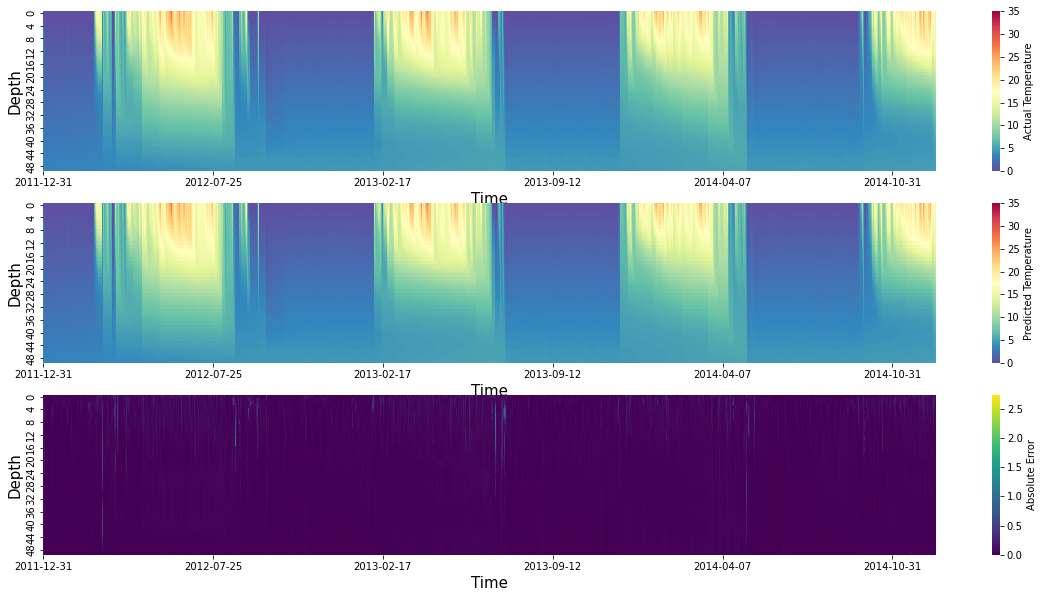

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [ ]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

In [ ]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [ ]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Mixing Model

## Convection Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Ice Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

# Finetuning

In [ ]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [ ]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [ ]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [ ]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out3 = torch.tensor(train_mean[m3_output_column_ix[0]]).float().to(device)
std_out3 = torch.tensor(train_std[m3_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m4_pred = ice_model(m4_input)
        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)

        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out3)/std_out3
        
        loss_m3 = criterion(m3_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m3
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [ ]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [ ]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

In [ ]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Mixing Model

## Convection Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Ice Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

# Compute Model Similarity after Finetuning

In [ ]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [ ]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
# Freeze all models again and compute finetuned diffusivity values

In [ ]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [ ]:
PATH = f"./saved_models/diffusion_model_finetuned.pth"
torch.save(heat_diff_model.state_dict(), PATH)

In [ ]:
def plot_output_freeLimits(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r')
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r')
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

In [ ]:
plot_output_freeLimits(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output_freeLimits(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))